In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:

RUN_ID = 86505

df_conditions = pd.read_csv(f'./results/{RUN_ID}/conditions.csv')
df_conditions_melted = df_conditions.melt(id_vars='generation', var_name='condition', value_name='value')

df_actions = pd.read_csv(f'./results/{RUN_ID}/actions.csv')
df_actions_melted = df_actions.melt(id_vars='generation', var_name='action', value_name='value')

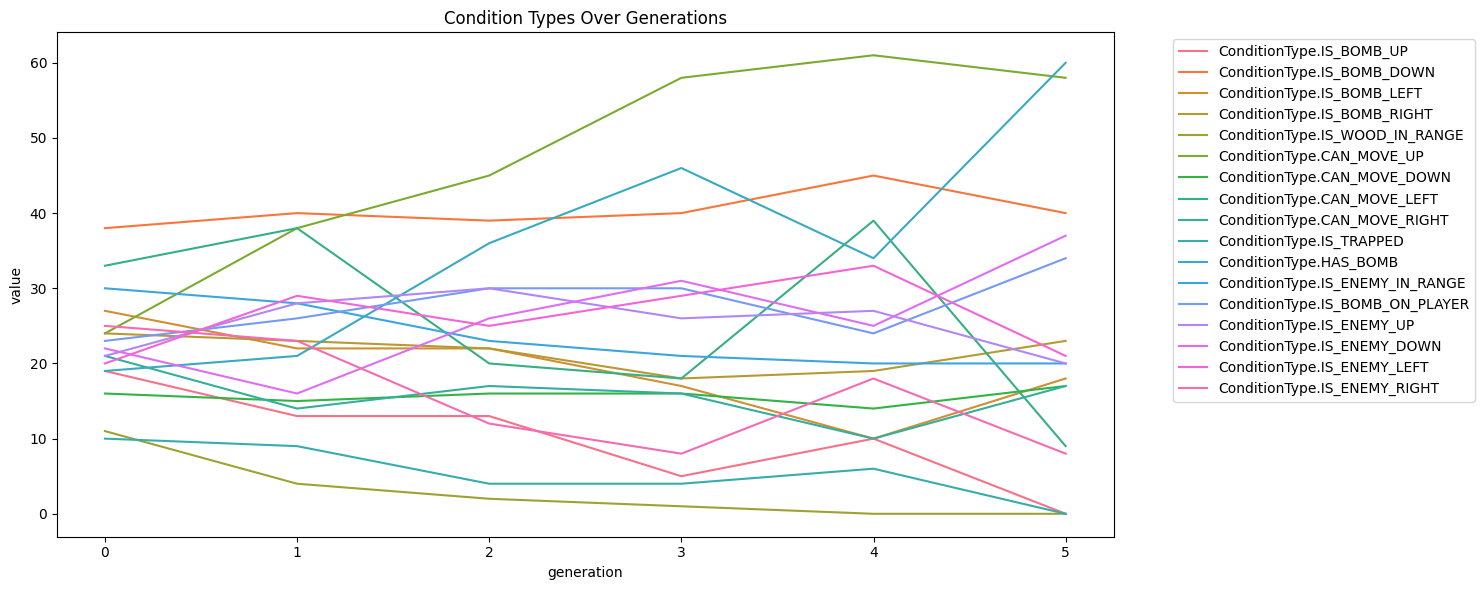

Final Generation Conditions:
ConditionType.HAS_BOMB             60
ConditionType.CAN_MOVE_UP          58
ConditionType.IS_BOMB_DOWN         40
ConditionType.IS_ENEMY_DOWN        37
ConditionType.IS_BOMB_ON_PLAYER    34
ConditionType.IS_BOMB_RIGHT        23
ConditionType.IS_ENEMY_LEFT        21
ConditionType.IS_ENEMY_UP          20
ConditionType.IS_ENEMY_IN_RANGE    20
ConditionType.IS_BOMB_LEFT         18
ConditionType.CAN_MOVE_RIGHT       17
ConditionType.CAN_MOVE_DOWN        17
ConditionType.CAN_MOVE_LEFT         9
ConditionType.IS_ENEMY_RIGHT        8
ConditionType.IS_TRAPPED            0
ConditionType.IS_WOOD_IN_RANGE      0
ConditionType.IS_BOMB_UP            0


In [59]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_conditions_melted, x='generation', y='value', hue='condition')
plt.title("Condition Types Over Generations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

final_generation = df_conditions['generation'].max()
final_generation_conditions = df_conditions[df_conditions['generation'] == final_generation].iloc[0].drop('generation')
print("Final Generation Conditions:")
print(final_generation_conditions.sort_values(ascending=False).to_string())

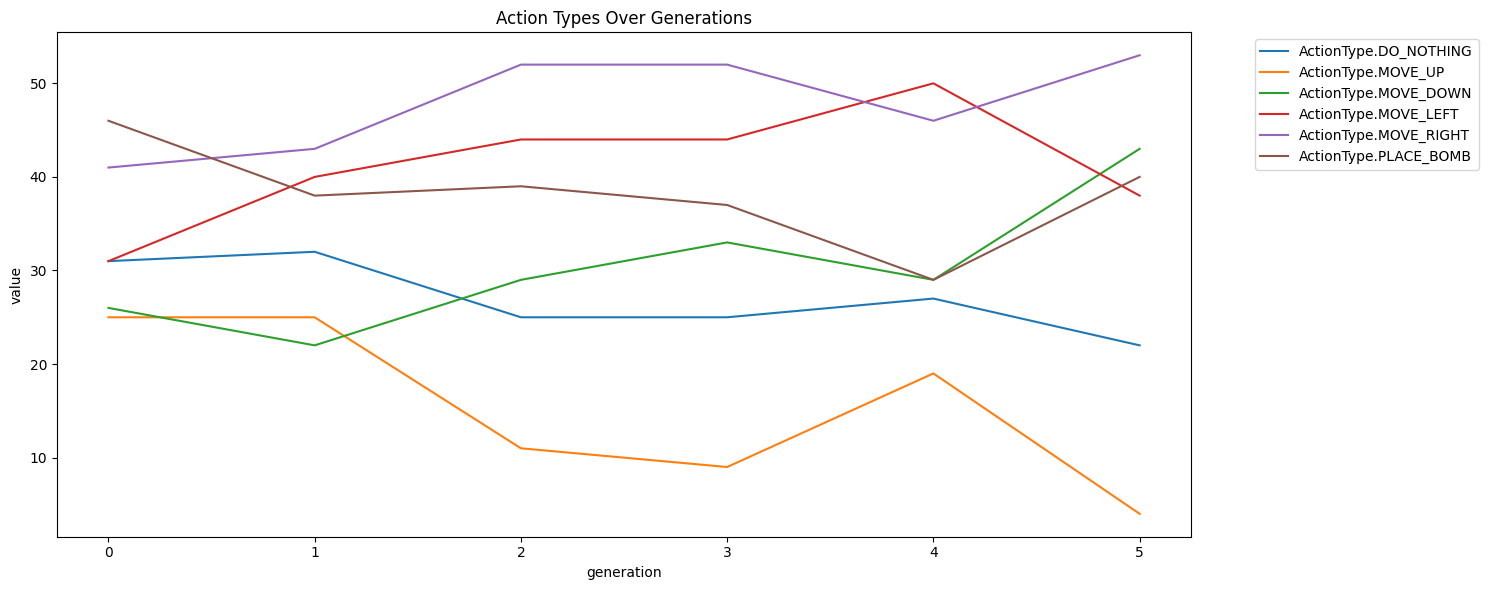

Final Generation Conditions:
ActionType.MOVE_RIGHT    53
ActionType.MOVE_DOWN     43
ActionType.PLACE_BOMB    40
ActionType.MOVE_LEFT     38
ActionType.DO_NOTHING    22
ActionType.MOVE_UP        4


In [60]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_actions_melted, x='generation', y='value', hue='action')
plt.title("Action Types Over Generations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

final_generation = df_actions['generation'].max()
final_generation_conditions = df_actions[df_actions['generation'] == final_generation].iloc[0].drop('generation')
print("Final Generation Conditions:")
print(final_generation_conditions.sort_values(ascending=False).to_string())